## Importing the Packages

In [1]:
from parser import parse_xml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
warnings.filterwarnings("ignore")
sns.set()

### Times Series Creation from XML

In [2]:
# Loading the data frame
df_comp = pd.DataFrame(parse_xml("./input/dblp-2021-02-01.xml"), columns=["year", "publications"])

Total titles found in file: 22643


In [3]:
# determining the key values as date
df_comp.year = pd.to_datetime(df_comp.year)


In [4]:
# setting the date as the index
df_comp.set_index("year", inplace=True)


In [5]:
# setting time series frequency as annual
df_comp = df_comp.asfreq('a')
df_comp.head()

,publications
year,
1954-12-31,1.0
1955-12-31,NaN
1956-12-31,NaN
1957-12-31,NaN
1958-12-31,1.0


### Handling missing values

In [6]:
# first check if there are missing values now that the frequency is set
df_comp.isna().sum()


publications    3
dtype: int64

In [7]:
# because we have 3 missing values we apply the ffill method to fill them
df_comp.publications = df_comp.publications.fillna(method="ffill")
df_comp.isna().sum()

publications    0
dtype: int64

### Creating a learning and testing set and plotting the series

In [8]:
end_date = "2015-12-31"
test_start_date = "2016-12-31"
test_end_date = "2019-12-31"
df = df_comp.loc[:end_date]
df_test = df_comp.loc[end_date:test_end_date]

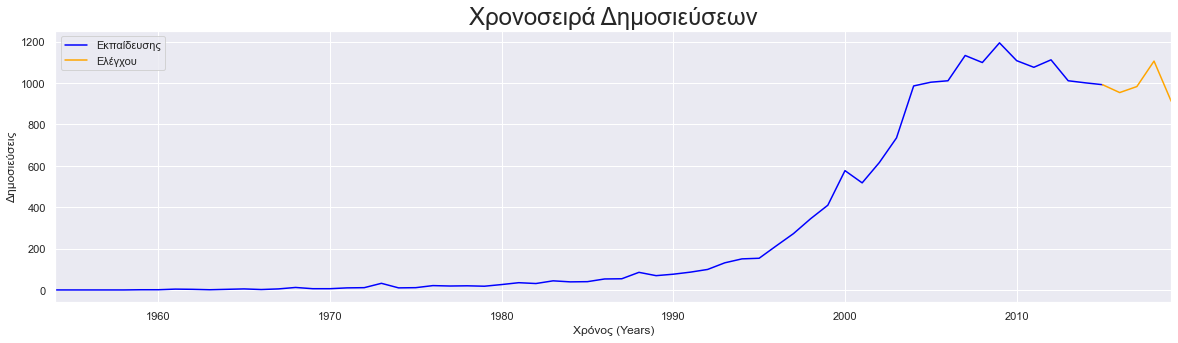

In [9]:
df.publications.plot(figsize=(20, 5), color="blue")
df_test.publications.plot(color="orange")
plt.xlabel("Χρόνος (Years)")
plt.ylabel("Δημοσιεύσεις")
plt.legend(["Εκπαίδευσης", "Ελέγχου"])
plt.title("Χρονοσειρά Δημοσιεύσεων", size=24)
plt.show()

### Checking Stationarity of the model

In [10]:
# Applying Augmented Dickey - Fuller test to check if the data is stationary
test_result = adfuller(df.publications)

print(f"ADF Statistic: {test_result[0]:.3f}")
print(f"p: {test_result[1]:.3f}")
print("Critical Values:")
res = [(lambda k, v: print(f"\t{k}: {v:.3f}"))(k, v) for k, v in test_result[4].items()]

ADF Statistic: 4.256
p: 1.000
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599


### Plotting the decomposed non-stationary data

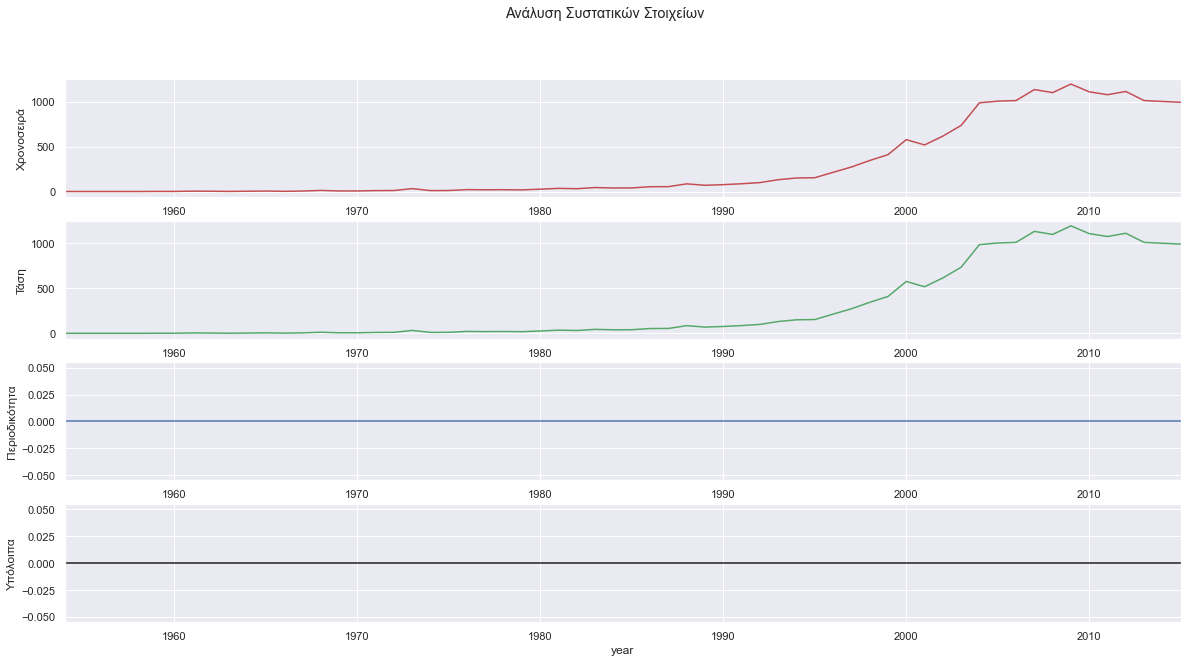

In [11]:
# We apply seasonal decomposition to the model
s_dec = seasonal_decompose(df.publications)

fig, axes = plt.subplots(4, 1, figsize=(20, 10))

s_dec.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Χρονοσειρά')
s_dec.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Τάση')
s_dec.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Περιοδικότητα')
s_dec.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Υπόλοιπα')
plt.suptitle("Ανάλυση Συστατικών Στοιχείων")
plt.show()
# the plot shows that there is no seasonality in the data and the residuals is stationary close to 0

### Making the series stationary

In [12]:
def get_stationarity(time_series):
    # rolling statistics
    rolling_mean = time_series.rolling(window=12).mean()
    rolling_std = time_series.rolling(window=12).std()

    # plotting rolling statistics
    plt.figure(figsize=(20, 6))
    original = plt.plot(time_series, color="blue", label="Χρονοσειρά")
    mean = plt.plot(rolling_mean, color="red", label="Μέση Τιμή")
    std = plt.plot(rolling_std, color="black", label="Τυπική Απόκλιση")
    plt.legend(loc="best")
    plt.title("Απαλοιφή Συστατικών", size=24)
    plt.xlabel("Χρόνος (έτη)")
    plt.ylabel("Δημοσιεύσεις")
    plt.show()

    # Dickey-Fuller test
    result = adfuller(time_series)

    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p: {result[1]:.3f}")
    print("Critical Values:")
    res = [(lambda k, v: print(f"\t{k}: {v:.3f}"))(k, v) for k, v in result[4].items()]

In [13]:
df["delta_publications"] = df.publications.diff(1)



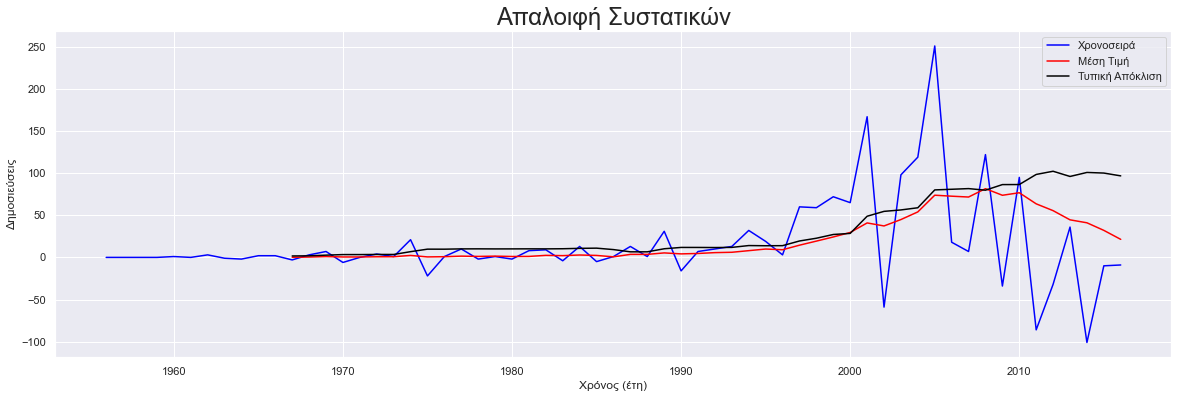

ADF Statistic: -1.871
p: 0.346
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596


In [14]:
get_stationarity(df.delta_publications[1:])
# delta_df is still not-stationary

In [15]:
# Adding another delta on the values
df["delta_2_publications"] = df.delta_publications.diff(1)

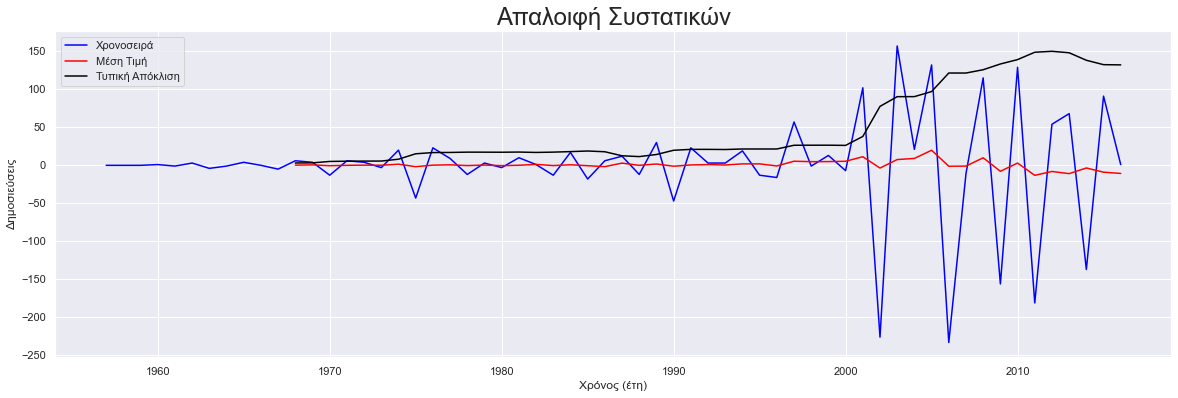

ADF Statistic: -3.745
p: 0.004
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


,publications,delta_publications,delta_2_publications
year,,,
2011-12-31,1076.0,-32.0,54.0
2012-12-31,1112.0,36.0,68.0
2013-12-31,1011.0,-101.0,-137.0
2014-12-31,1001.0,-10.0,91.0
2015-12-31,992.0,-9.0,1.0


In [16]:
get_stationarity(df.delta_2_publications[2:])
# delta_2_df is stationary
df.tail()

### ACF for delta 2 publications

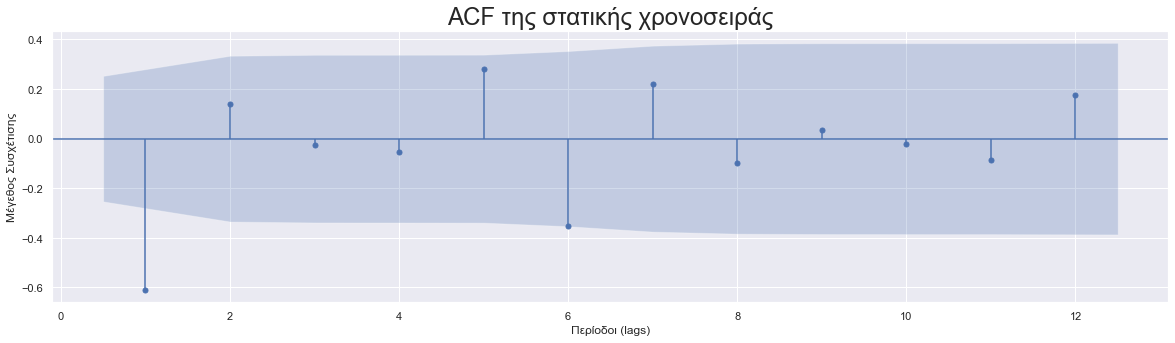

In [17]:
_, axes = plt.subplots(figsize=(20, 5))
sgt.plot_acf(df.delta_2_publications[2:], zero=False, lags=12, ax=axes)
plt.title("ACF της στατικής χρονοσειράς", size=24)
plt.xlabel("Περίοδοι (lags)")
plt.ylabel("Μέγεθος Συσχέτισης")
plt.show()
# the 2nd and the 5th coefficients are significant

### PACF for delta publications

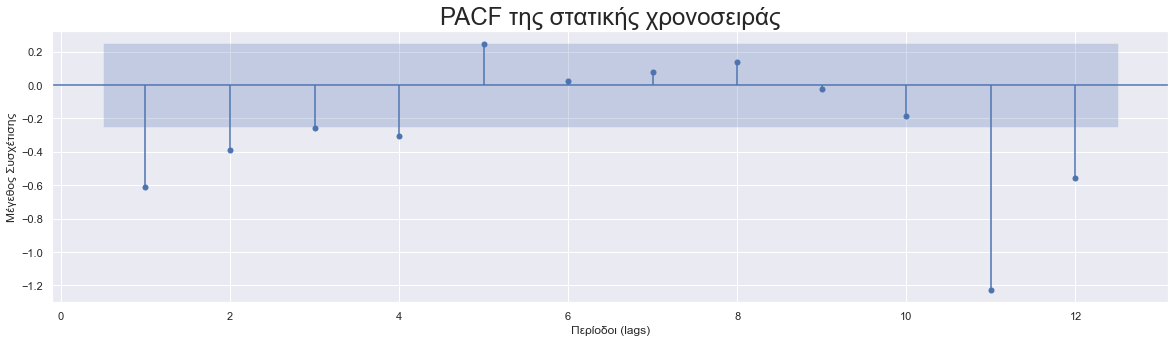

In [18]:
_, axes = plt.subplots(figsize=(20, 5))
sgt.plot_pacf(df.delta_2_publications[2:], lags=12, zero=False,
              method="ols", ax=axes)
plt.title("PACF της στατικής χρονοσειράς", size=24)
plt.xlabel("Περίοδοι (lags)")
plt.ylabel("Μέγεθος Συσχέτισης")
plt.show()
# the 2nd, 5th and  6th coefficients are significant

### Finding the best ARMA model


In [19]:
# df.tail()
model_delta_ar_4_i_2_ma_1 = ARIMA(df.publications[3:], order=(4, 2, 1))
results_delta_ar_4_i_2_ma_1 = model_delta_ar_4_i_2_ma_1.fit()
results_delta_ar_4_i_2_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.publications   No. Observations:                   57
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -301.868
Method:                       css-mle   S.D. of innovations             47.669
Date:                Sat, 17 Apr 2021   AIC                            617.737
Time:                        20:18:17   BIC                            632.038
Sample:                    12-31-1959   HQIC                           623.295
                         - 12-31-2015                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3802      2.019     -0.188      0.851      -4.337       3.576
ar.L1.D2.publications    -1.4083      0.253     -5.566      0.000      -1.904      -0.912
ar.L2.D2.publications    -1.1272      0.275     -4.093      0.000      -1.667      -0.587
ar.L3.D2.publications    -0.7697      0.225     -3.424      0.001      -1.210      -0.329
ar.L4.D2.publications    -0.4086      0.122     -3.339      0.001      -0.649      -0.169
ma.L1.D2.publications     0.4717      0.267      1.765      0.078      -0.052       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0959           -1.3334j            1.3369           -0.2386
AR.2            0.0959           +1.3334j            1.3369            0.2386
AR.3           -1.0376           -0.5410j            1.1702           -0.4235
AR.4           -1.0376           +0.5410j            1.1702            0.4235
MA.1           -2.1202           +0.0000j            2.1202            0.5000
-----------------------------------------------------------------------------
"""

### Plotting ACF, PACF of the residuals for the bets model

In [20]:
df["res_ar_4_int_2_ma_1"] = results_delta_ar_4_i_2_ma_1.resid

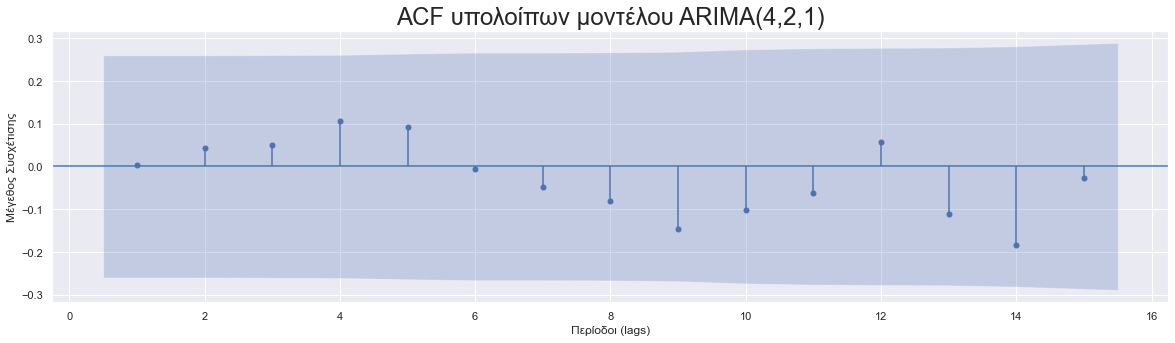

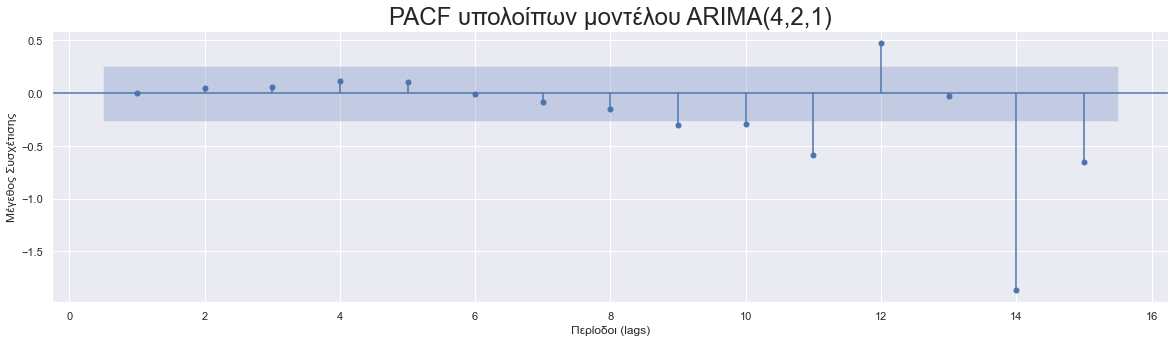

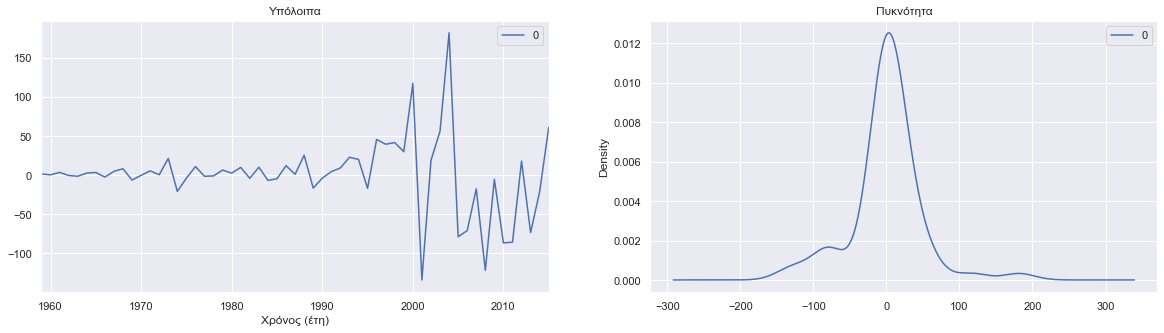

In [21]:
_, axes = plt.subplots(figsize=(20, 5))
sgt.plot_acf(df.res_ar_4_int_2_ma_1[5:], zero=False, lags=15, ax=axes)
plt.title("ACF υπολοίπων μοντέλου ARIMA(4,2,1)", size=24)
plt.xlabel("Περίοδοι (lags)")
plt.ylabel("Μέγεθος Συσχέτισης")
plt.show()

_, axes = plt.subplots(figsize=(20, 5))
sgt.plot_pacf(df.res_ar_4_int_2_ma_1[5:], zero=False, lags=15,
              method="ols", ax=axes)
plt.title("PACF υπολοίπων μοντέλου ARIMA(4,2,1)", size=24)
plt.xlabel("Περίοδοι (lags)")
plt.ylabel("Μέγεθος Συσχέτισης")
plt.show()

# Plot residual errors
residuals = pd.DataFrame(results_delta_ar_4_i_2_ma_1.resid)
_, ax = plt.subplots(1,2, figsize=(20, 5))
residuals.plot(title="Υπόλοιπα", ax=ax[0])
ax[0].set_xlabel('Χρόνος (έτη)')
residuals.plot(kind='kde', title='Πυκνότητα', ax=ax[1])
plt.show()

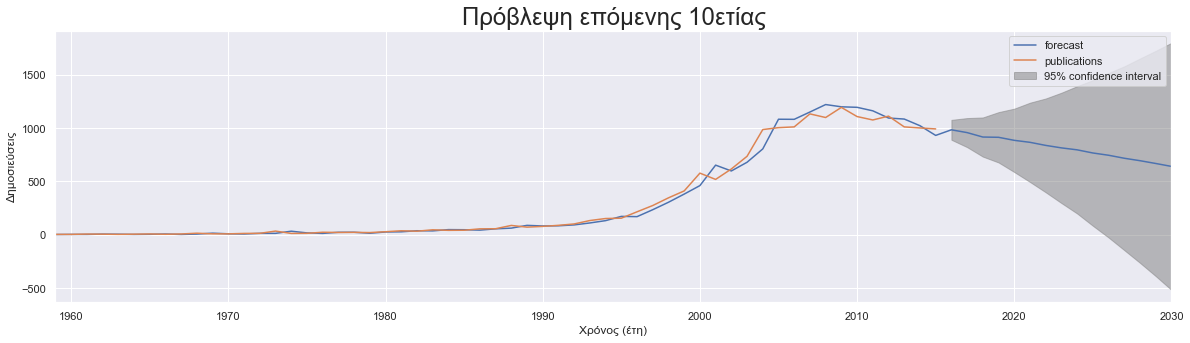

In [22]:
_, ax = plt.subplots(figsize=(20, 5))
_ = results_delta_ar_4_i_2_ma_1.plot_predict("1959", "2030", dynamic=False, ax=ax)
plt.legend(["Πρόβλεψη", "Πραγματικά", "95% κάλυψης"], loc="best")
plt.xlabel("Χρόνος (έτη)")
plt.ylabel("Δημοσιεύσεις")
plt.title("Πρόβλεψη επόμενης 10ετίας", size=24)
plt.legend(loc="best")
plt.show()


In [23]:
# Forecast
fc, se, conf = results_delta_ar_4_i_2_ma_1.forecast(5, alpha=0.05)  # 95% conf


In [24]:
# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

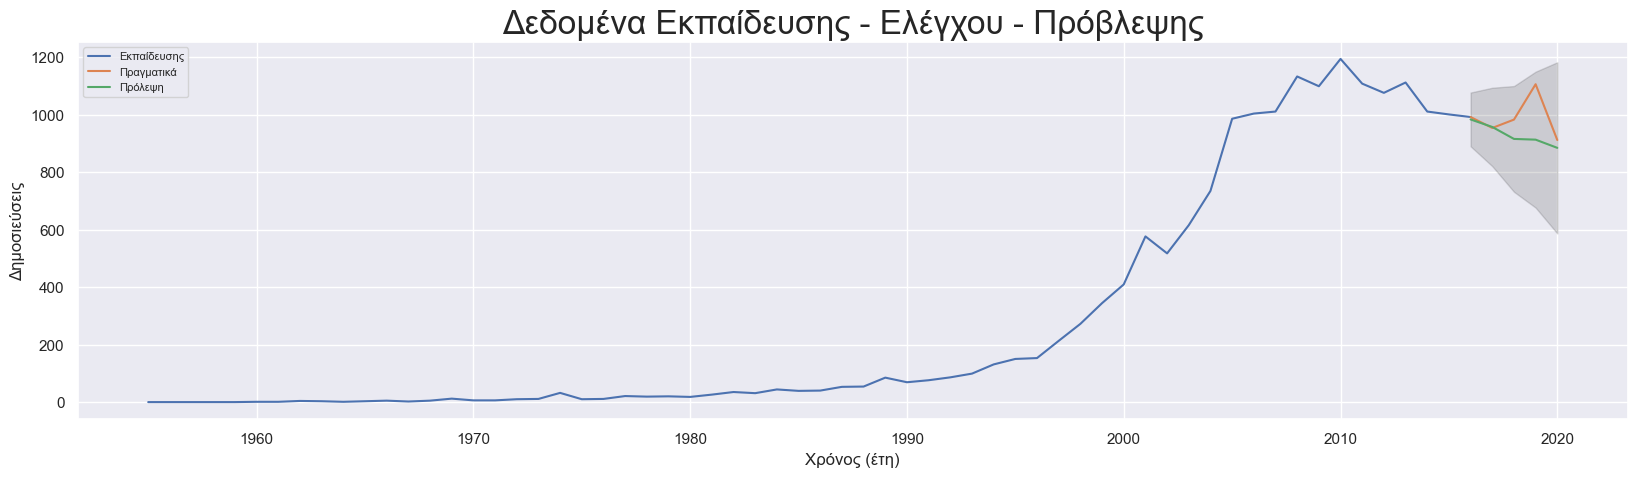

In [25]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(df.publications, label='Εκπαίδευσης')
plt.plot(df_test.publications, label='Πραγματικά')
plt.plot(fc_series, label='Πρόβλεψη')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Δεδομένα Εκπαίδευσης - Ελέγχου - Πρόβλεψης', size=24)
plt.legend(["Εκπαίδευσης", "Πραγματικά", "Πρόλεψη"], loc='upper left', fontsize=8)
plt.xlabel("Χρόνος (έτη)")
plt.ylabel("Δημοσιεύσεις")
plt.show()

In [26]:
# Accuracy metrics
def forecast_accuracy(forecast, actual) -> dict :
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape': mape, 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, # 'acf1':acf1,
            'corr': corr, 'minmax':minmax})

In [27]:
res = forecast_accuracy(fc, df_test.publications)
p = [(lambda k, v: print(f"{k}:\t{v:.3f}"))(k, v) for k, v in res.items()]

mape:	0.057
me:	-58.417
mae:	59.771
mpe:	-0.055
rmse:	92.159
corr:	0.072
minmax:	0.057


### Trying a different model

In [34]:
model_ar_5_int_2_ma_6 = ARIMA(df.publications[1:], order=(5, 2, 6))
results_ar_5_int_2_ma_6 = model_ar_5_int_2_ma_6.fit(start_ar_lags=4)
results_ar_5_int_2_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.publications   No. Observations:                   59
Model:                 ARIMA(5, 2, 6)   Log Likelihood                -317.941
Method:                       css-mle   S.D. of innovations             40.042
Date:                Sat, 17 Apr 2021   AIC                            661.882
Time:                        20:45:26   BIC                            688.890
Sample:                    12-31-1957   HQIC                           672.424
                         - 12-31-2015                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6613      0.623      1.062      0.288      -0.559       1.882
ar.L1.D2.publications    -0.6718        nan        nan        nan         nan         nan
ar.L2.D2.publications     1.1227        nan        nan        nan         nan         nan
ar.L3.D2.publications     1.2198        nan        nan        nan         nan         nan
ar.L4.D2.publications    -0.5352   5.56e-05  -9632.728      0.000      -0.535      -0.535
ar.L5.D2.publications    -0.8639      0.000  -2860.693      0.000      -0.864      -0.863
ma.L1.D2.publications    -0.3852      0.353     -1.093      0.274      -1.076       0.306
ma.L2.D2.publications    -1.4426      0.171     -8.413      0.000      -1.779      -1.107
ma.L3.D2.publications -4.823e-16      0.562  -8.59e-16      1.000      -1.101       1.101
ma.L4.D2.publications     1.4426      0.396      3.642      0.000       0.666       2.219
ma.L5.D2.publications     0.3852      0.310      1.241      0.214      -0.223       0.993
ma.L6.D2.publications    -1.0000      0.348     -2.877      0.004      -1.681      -0.319
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9885           -0.3400j            1.0453           -0.0527
AR.2            0.9885           +0.3400j            1.0453            0.0527
AR.3           -0.7686           -0.6398j            1.0000           -0.3895
AR.4           -0.7686           +0.6398j            1.0000            0.3895
AR.5           -1.0594           -0.0000j            1.0594           -0.5000
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2           -0.6910           -0.7228j            1.0000           -0.3714
MA.3           -0.6910           +0.7228j            1.0000            0.3714
MA.4            0.8837           -0.4681j            1.0000           -0.0775
MA.5            0.8837           +0.4681j            1.0000            0.0775
MA.6            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

In [35]:
df["res_ar_5_int_2_ma_6"] = results_ar_5_int_2_ma_6.resid

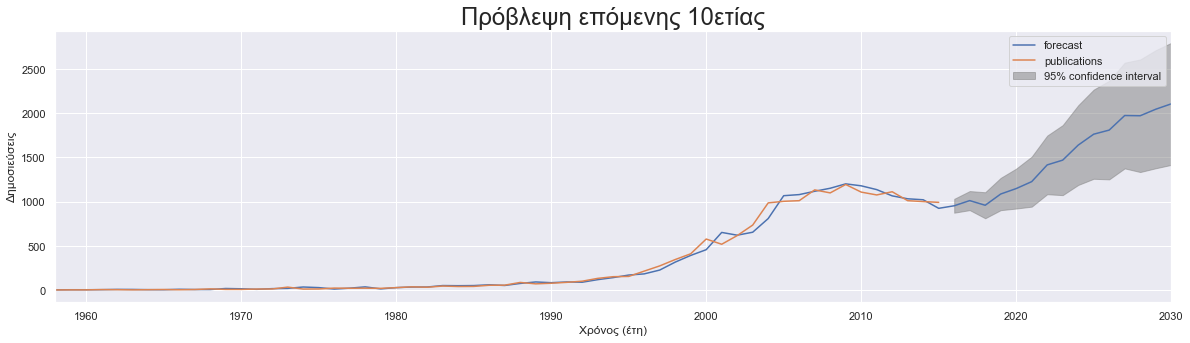

In [36]:
_, ax = plt.subplots(figsize=(20, 5))
_ = results_ar_5_int_2_ma_6.plot_predict("1958", "2030", dynamic=False, ax=ax)
plt.legend(["Πρόβλεψη", "Πραγματικά", "95% κάλυψης"], loc="best")
plt.xlabel("Χρόνος (έτη)")
plt.ylabel("Δημοσιεύσεις")
plt.title("Πρόβλεψη επόμενης 10ετίας", size=24)
plt.legend(loc="best")
plt.show()

In [37]:
# Forecast
fc, se, conf = results_ar_5_int_2_ma_6.forecast(5, alpha=0.05)  # 95% conf


In [38]:
# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

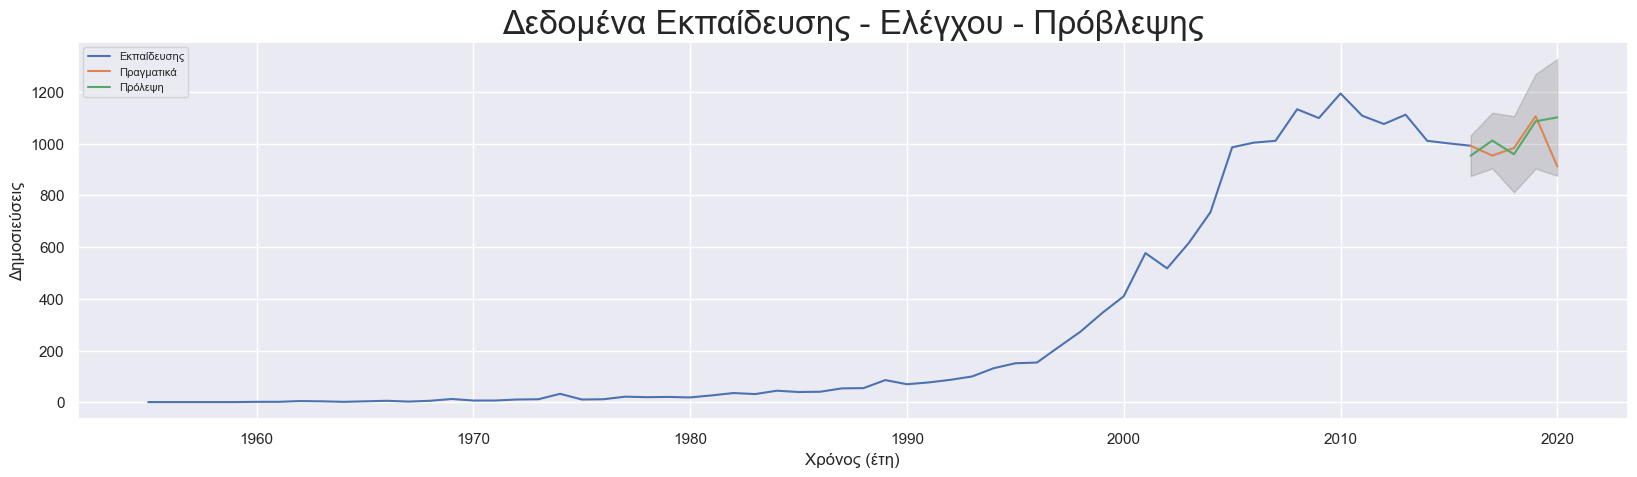

In [39]:
# Plot
plt.figure(figsize=(20,5), dpi=100)
plt.plot(df.publications, label='Εκπαίδευσης')
plt.plot(df_test.publications, label='Πραγματικά')
plt.plot(fc_series, label='Πρόβλεψη')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Δεδομένα Εκπαίδευσης - Ελέγχου - Πρόβλεψης', size=24)
plt.legend(["Εκπαίδευσης", "Πραγματικά", "Πρόλεψη"], loc='upper left', fontsize=8)
plt.xlabel("Χρόνος (έτη)")
plt.ylabel("Δημοσιεύσεις")
plt.show()

In [40]:
res = forecast_accuracy(fc, df_test.publications)
p = [(lambda k, v: print(f"{k}:\t{v:.3f}"))(k, v) for k, v in res.items()]


mape:	0.070
me:	33.123
mae:	65.931
mpe:	0.038
rmse:	91.406
corr:	0.096
minmax:	0.062
